In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

import matplotlib.colors as mcolors

from encoding_information.datasets.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

def marker_for_channel(channel):
    if channel == 'LED119':
        marker = 'x'
    elif channel == 'DPC_Right':
        marker = 'v'
    elif channel == 'Brightfield':
        marker = 'o'
    return marker




2024-11-04 11:47:16.819964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


In [2]:
from matplotlib.colors import LinearSegmentedColormap

experiment_dir = '/home/hpinkard_waller/models/Synthetic_Noise_v11/'
patch_size = 40

mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
phenotype_nlls = {}
phenotype_marker_indices = {}
for dir_name in os.listdir(experiment_dir):
    # check if complete.txt is in this directory
    if not os.path.exists(os.path.join(experiment_dir, dir_name, 'complete.txt')):
        # print('Skipping', dir_name)
        continue
    if 'Analysis' in dir_name:
        config_file_name = [d for d in os.listdir(os.path.join(experiment_dir, dir_name)) if '.yaml' in d][0]
        config_file_full_path = os.path.join(experiment_dir, dir_name, config_file_name)
        config = yaml.load(open(config_file_full_path, 'r'), Loader=yaml.FullLoader)
        if config['patch_size'] != patch_size:
            continue
        photons_per_pixel = config['data']['synthetic_noise']['photons_per_pixel']
        channel = config['data']['channels'][0]
        replicate = config['metadata']['replicate']
        saving_dir = os.path.join(experiment_dir, dir_name)
        analysis_dir = os.path.join(saving_dir, 'analysis')
        mi_estimate_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'mi_estimates' in f][0]))
        # mi_estimates_gp[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_gp']


        mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)] = (mi_estimate_file['mi_pixel_cnn'], 
                                                                           mi_estimate_file['pixel_cnn_lower_bound'], 
                                                                            mi_estimate_file['pixel_cnn_upper_bound'])
        nll_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'phenotyping_nll' in f][0]))
        phenotype_nlls[(channel, photons_per_pixel, replicate)] = nll_file['nlls']
        phenotype_marker_indices[(channel, photons_per_pixel, replicate)] = nll_file['marker_indices']

        # print the channel, photons and mi_gp
        print(channel, photons_per_pixel, mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)])    



# Set up the colormap
base_colormap = plt.cm.get_cmap('inferno')
start, end = 0, 0.85

colormap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_colormap.name, a=start, b=end),
    base_colormap(np.linspace(start, end, 256))
)

photon_levels = sorted(list(set([p for (c, p, r) in mi_estimates_pixel_cnn.keys()])))
min_photons_per_pixel = min(photon_levels)
max_photons_per_pixel = max(photon_levels)

min_log_photons = np.log(min_photons_per_pixel)
max_log_photons = np.log(max_photons_per_pixel)

def color_for_photon_level(photons_per_pixel):
    log_photons = np.log(photons_per_pixel)
    return colormap((log_photons - min_log_photons) / (max_log_photons - min_log_photons) )


LED119 450 (array(0.39648707), array(0.38901361), array(0.40280408))
LED119 50 (array(0.23018565), array(0.22426422), array(0.23479444))
Brightfield 150 (array(0.05092591), array(0.04921553), array(0.05261838))
Brightfield 50 (array(0.02812042), array(0.02595966), array(0.02983975))
Brightfield 50 (array(0.02755081), array(0.02549109), array(0.02930229))
DPC_Right 450 (array(0.25219318), array(0.24755572), array(0.25751074))
Brightfield 50 (array(0.02480253), array(0.02260056), array(0.02680997))
DPC_Right 450 (array(0.25449156), array(0.24942119), array(0.25901764))
Brightfield 50 (array(0.02494562), array(0.0227066), array(0.02666962))
Brightfield 150 (array(0.05052691), array(0.04909717), array(0.05209736))
DPC_Right 450 (array(0.25207005), array(0.24642697), array(0.25655735))
LED119 150 (array(0.31908536), array(0.31429524), array(0.32463919))
LED119 150 (array(0.31765791), array(0.31206404), array(0.32449639))
LED119 50 (array(0.22591567), array(0.22136327), array(0.23074275))
LE

/tmp/ipykernel_2460403/1058474305.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


# plot individual trials

/tmp/ipykernel_2460403/3460489802.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


450 (0.983196, 0.743758, 0.138453, 1.0)
450 (0.983196, 0.743758, 0.138453, 1.0)
450 (0.983196, 0.743758, 0.138453, 1.0)


/tmp/ipykernel_2460403/3460489802.py:117: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax2.errorbar(mi[0], ll[0], yerr=[[lower], [upper]], fmt='.-',


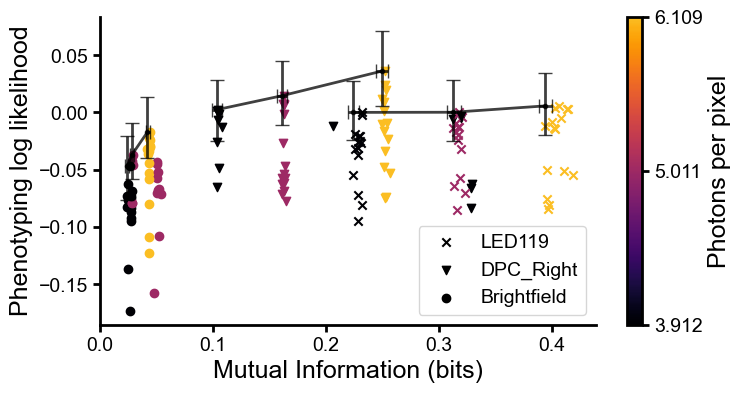

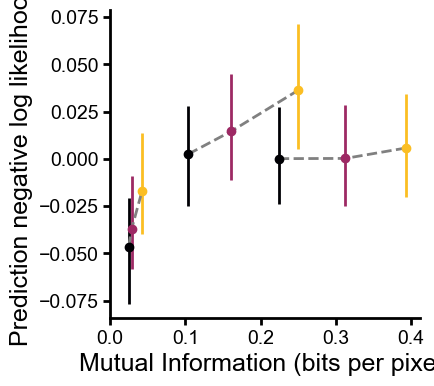

In [7]:
nll_conf_int = 0.9
num_resamples = 100

# mi_estimates_to_use = mi_estimates_gp
mi_estimates_to_use = mi_estimates_pixel_cnn


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))

base_colormap = plt.cm.get_cmap('inferno')
# Define the start and end points of colormap--used so that high values aren't too light against white background
start, end = 0, 0.85

from matplotlib.colors import LinearSegmentedColormap
# Create a new colormap from the portion of the original colormap
colormap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_colormap.name, a=start, b=end),
    base_colormap(np.linspace(start, end, 256))
)

photon_levels = sorted(list(set([p for (c, p, r) in mi_estimates_to_use.keys()])))
min_photons_per_pixel =  min(photon_levels)
max_photons_per_pixel =  max(photon_levels)

min_log_photons = np.log(min_photons_per_pixel)
max_log_photons = np.log(max_photons_per_pixel)

def color_for_photon_level(photons_per_pixel):
    log_photons = np.log(photons_per_pixel)
    return colormap((log_photons - min_log_photons) / (max_log_photons - min_log_photons) )

def marker_for_channel(channel):
    if channel == 'LED119':
        marker = 'x'
    elif channel == 'DPC_Right':
        marker = 'v'
    elif channel == 'Brightfield':
        marker = 'o'
    return marker


# iterate through all the tuples and make a scatter plot
for channel, photons_per_pixel, replicate in mi_estimates_to_use.keys():
    mi, mi_lower, mi_upper = mi_estimates_to_use[(channel, photons_per_pixel, replicate)]
    nlls = phenotype_nlls[(channel, photons_per_pixel, replicate)]
    marker_indices = phenotype_marker_indices[(channel, photons_per_pixel, replicate)]

    marker = marker_for_channel(channel)
    color = color_for_photon_level(photons_per_pixel)

    ax.scatter(mi, -nlls.mean(), color=color, marker=marker)

# sort by channel and photons per pixel
channel_photons_results = {}
for (c, p, r) in mi_estimates_to_use.keys():
    if c not in channel_photons_results:
        channel_photons_results[c] = {}
    if p not in channel_photons_results[c]:
        channel_photons_results[c][p] = []
    mi = mi_estimates_to_use[(c, p, r)]
    nlls = phenotype_nlls[(c, p, r)]

    # compute error bar for nll mean
    nll_reasmpled = nlls[np.random.choice(nlls.shape[0], (num_resamples, nlls.shape[0]), replace=True)]
    mean_estimates = nll_reasmpled.mean(axis=1)
    # take percentile
    lower_bound = np.percentile(mean_estimates, 100 * (1 - nll_conf_int) / 2)
    upper_bound = np.percentile(mean_estimates, 100 * (1 + nll_conf_int) / 2)
    nll_mean = nlls.mean()
    channel_photons_results[c][p].append((mi, (nll_mean, lower_bound, upper_bound)))



# plot the mean and std for each channel
for channel in channel_photons_results.keys():
    # take mean of each photon per pixel
    mi_to_use = []
    ll_to_use = []
    photons_per_pixel = sorted(channel_photons_results[channel].keys())
    for photons in photons_per_pixel:
        mi, nll = zip(*channel_photons_results[channel][photons])
        mi = np.array(mi)
        nll = np.array(nll)

        best_mi_index = np.argmin(mi[:, 0])
        mi_to_use.append(mi[best_mi_index])


        # nll_index_to_use = np.argmin(nll[:, 0])
        # use kth from best
        nll_index_to_use = np.argsort(nll[:, 0])[0]
        lls = -nll[nll_index_to_use]

        ll_to_use.append(lls)

    
    ll_to_use = np.array(ll_to_use)
    mi_to_use = np.array(mi_to_use)
    
    mi_lower_bound = np.abs(mi_to_use[:, 2] - mi_to_use[:, 0])
    mi_upper_bound = np.abs(mi_to_use[:, 1] - mi_to_use[:, 0])

    lower_bound = np.abs(ll_to_use[:, 2] - ll_to_use[:, 0])
    upper_bound = np.abs(ll_to_use[:, 1] - ll_to_use[:, 0])
    # plot error bars for nll
    ax.errorbar(mi_to_use[:, 0], ll_to_use[:, 0], yerr=[lower_bound, upper_bound], 
                xerr=[mi_lower_bound, mi_upper_bound],
                fmt='.-', color='black', alpha=0.75, linewidth=2, capsize=5)
    # plot medians, lines, fill between
    
    print(photons, color_for_photon_level(photons))
    # ax2.scatter(mi_to_use[:, 0], -ll_to_use[:, 0], color=[color_for_photon_level(p) for p in photons_per_pixel],
    #              marker=marker_for_channel(channel), s=50, zorder=100)
    # plot with just a y error bar with no cap
    for mi, ll, lower, upper, p in zip(mi_to_use, ll_to_use, lower_bound, upper_bound, photons_per_pixel):
        ax2.errorbar(mi[0], ll[0], yerr=[[lower], [upper]], fmt='.-', 
                     color=color_for_photon_level(p),
                      linewidth=2, capsize=0, marker='o')
    #     ax2.plot(mi[0], ll[0], '--', color='grey', alpha=1, linewidth=2)
    # ax2.errorbar(mi_to_use[:, 0], ll_to_use[:, 0], yerr=[lower_bound, upper_bound], fmt='.-', 
    #              color=color_for_photon_level(p),
    #               linewidth=2, capsize=0, marker='o')
    ax2.plot(mi_to_use[:, 0], ll_to_use[:, 0], '--', color='grey', alpha=1, linewidth=2)
    # ax2.fill_between(mi_to_use[:, 0], -ll_to_use[:, 1], -ll_to_use[:, 2], alpha=0.5, color='gray')

ax2.set(xlim=[0, None])
clear_spines(ax2)
ax2.set_xlabel('Mutual Information (bits per pixel)')
ax2.set_ylabel('Prediction negative log likelihood')
fig2.savefig('/home/hpinkard_waller/figures/phenotyping/bsccm_phenotyping_mi_vs_nll.pdf')


ax.set_xlabel('Mutual Information (bits)')
ax.set_ylabel('Phenotyping log likelihood')
clear_spines(ax)
# legend
ax.scatter([], [], color='k', marker='x', label='LED119')
ax.scatter([], [], color='k', marker='v', label='DPC_Right')
ax.scatter([], [], color='k', marker='o', label='Brightfield')
ax.legend(loc='lower right', frameon=True)
ax.set_xlim([0, None])

cmap = plt.get_cmap('inferno')

# colorbar
norm = mpl.colors.Normalize(vmin=min_log_photons, vmax=max_log_photons)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=(np.log(photon_levels)))
# set tick labels
# cbar.ax.set_yticklabels([min_photons_per_pixel, max_photons_per_pixel])



cbar.set_label('Photons per pixel')

# ax.set_ylim([-.15, None])
# ax.set_xlim([-1, .4])

# compute bootstrapped error for just a single model

/tmp/ipykernel_1864018/2755643116.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


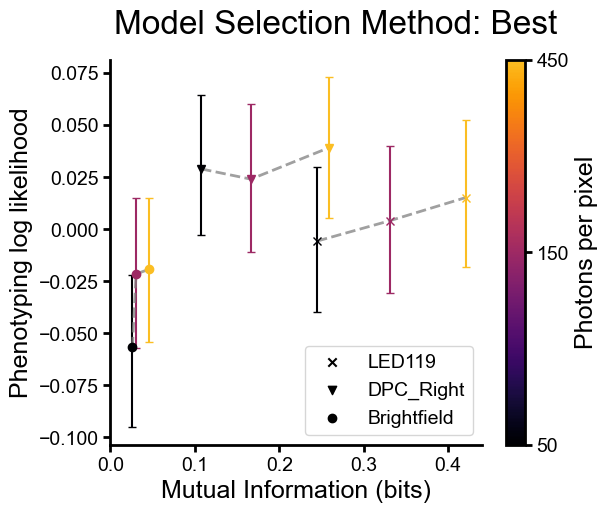

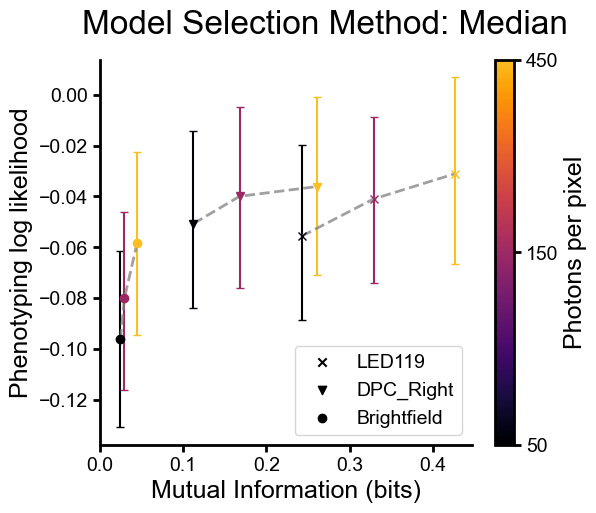

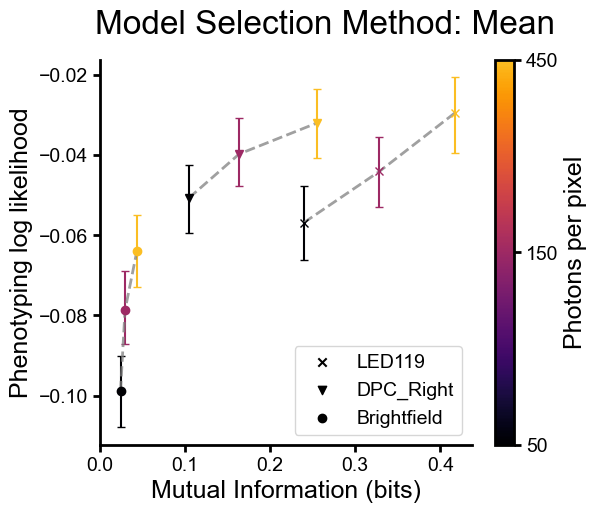

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Assuming mi_estimates_pixel_cnn, phenotype_nlls, and phenotype_marker_indices are already defined
mi_estimates_to_use = mi_estimates_pixel_cnn



def clear_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# List of model selection methods
model_selection_methods = ['best', 'median', 'mean']

# Loop over each model selection method
for model_selection_method in model_selection_methods:
    # Create a new figure for each method
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle(f"Model Selection Method: {model_selection_method.capitalize()}")

    # Collect all models for each channel and photon count
    models_by_key = {}

    for (channel, photons_per_pixel, replicate) in mi_estimates_to_use.keys():
        key = (channel, photons_per_pixel)
        nlls = phenotype_nlls[(channel, photons_per_pixel, replicate)]
        mean_nll = nlls.mean()

        model_info = {
            'replicate': replicate,
            'mean_nll': mean_nll,
            'nlls': nlls,
            'mi': mi_estimates_to_use[(channel, photons_per_pixel, replicate)]
        }

        if key not in models_by_key:
            models_by_key[key] = []
        models_by_key[key].append(model_info)

    # Select the model based on the selection method
    selected_models = {}

    for key in models_by_key:
        models = models_by_key[key]
        # Sort models by mean NLL
        models.sort(key=lambda x: x['mean_nll'])
        
        if model_selection_method == 'best':
            # Select the best model (lowest mean NLL)
            selected_model = models[0]
        elif model_selection_method == 'median':
            # Select the median model
            median_index = len(models) // 2
            selected_model = models[median_index]
        elif model_selection_method == 'mean':
            # Compute the mean NLLs and MI across all models
            mean_nll = np.mean([m['mean_nll'] for m in models])
            # Stack all NLLs for bootstrapping
            all_nlls = np.concatenate([m['nlls'].flatten() for m in models])
            # Take min MI estiamte -- not exactly correct but should be close
            mean_mi = np.min([m['mi'] for m in models])

            selected_model = {
                'mean_nll': mean_nll,
                'nlls': all_nlls,
                'mi': mean_mi
            }
        else:
            raise ValueError("Invalid model_selection_method. Choose 'best', 'median', or 'mean'.")

        selected_models[key] = selected_model

    # Compute error bars by bootstrapping
    num_bootstrap_samples = 1000

    for key in selected_models:
        nlls = selected_models[key]['nlls']
        bootstrap_means = []
        n_samples = len(nlls)

        for i in range(num_bootstrap_samples):
            resampled_nlls = np.random.choice(nlls.flatten(), size=n_samples, replace=True)
            bootstrap_mean = resampled_nlls.mean()
            bootstrap_means.append(bootstrap_mean)

        bootstrap_means = np.array(bootstrap_means)
        mean_bootstrap_mean = bootstrap_means.mean()
        std_bootstrap_mean = bootstrap_means.std()
        ci_lower, ci_upper = np.percentile(bootstrap_means, [2.5, 97.5])

        selected_models[key]['bootstrap_mean'] = mean_bootstrap_mean
        selected_models[key]['bootstrap_std'] = std_bootstrap_mean
        selected_models[key]['ci_lower'] = ci_lower
        selected_models[key]['ci_upper'] = ci_upper

    # Plot the data with error bars
    for key in selected_models:
        channel, photons_per_pixel = key
        mi = selected_models[key]['mi']
        mean_nll = selected_models[key]['mean_nll']
        ci_lower = selected_models[key]['ci_lower']
        ci_upper = selected_models[key]['ci_upper']
        yerr_lower = mean_nll - ci_lower
        yerr_upper = ci_upper - mean_nll
        yerr = [[yerr_lower], [yerr_upper]]

        marker = marker_for_channel(channel)
        color = color_for_photon_level(photons_per_pixel)

        ax.errorbar(mi, -mean_nll, yerr=yerr, fmt=marker, color=color, ecolor=color, capsize=3)

    # Optionally, plot lines connecting the points for each channel
    channels = set([key[0] for key in selected_models.keys()])
    for channel in channels:
        data_points = []
        for key in selected_models:
            if key[0] == channel:
                mi = selected_models[key]['mi']
                mean_nll = selected_models[key]['mean_nll']
                data_points.append((mi, mean_nll))
        data_points.sort(key=lambda x: x[0])
        mi_values, mean_nll_values = zip(*data_points)
        ax.plot(mi_values, -np.array(mean_nll_values), '--', color='grey', alpha=0.75, linewidth=2)

    # Finalize the plot
    ax.set_xlabel('Mutual Information (bits)')
    ax.set_ylabel('Phenotyping log likelihood')
    clear_spines(ax)

    # Legend
    ax.scatter([], [], color='k', marker='x', label='LED119')
    ax.scatter([], [], color='k', marker='v', label='DPC_Right')
    ax.scatter([], [], color='k', marker='o', label='Brightfield')
    ax.legend(loc='lower right', frameon=True)
    ax.set_xlim([0, None])

    # Colorbar
    norm = mpl.colors.Normalize(vmin=min_log_photons, vmax=max_log_photons)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=np.log(photon_levels))
    cbar.set_label('Photons per pixel')
    cbar.ax.set_yticklabels([str(int(np.round(np.exp(tick)))) for tick in cbar.get_ticks()])


## Now make the plot with median estimates of accuracy and bootstrapped error bars

/tmp/ipykernel_2194719/3533990221.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


(0.001462, 0.000466, 0.013866, 1.0)
(0.615513, 0.161817, 0.391219, 1.0)
(0.983196, 0.743758, 0.138453, 1.0)
(0.001462, 0.000466, 0.013866, 1.0)
(0.615513, 0.161817, 0.391219, 1.0)
(0.983196, 0.743758, 0.138453, 1.0)
(0.001462, 0.000466, 0.013866, 1.0)
(0.615513, 0.161817, 0.391219, 1.0)
(0.983196, 0.743758, 0.138453, 1.0)


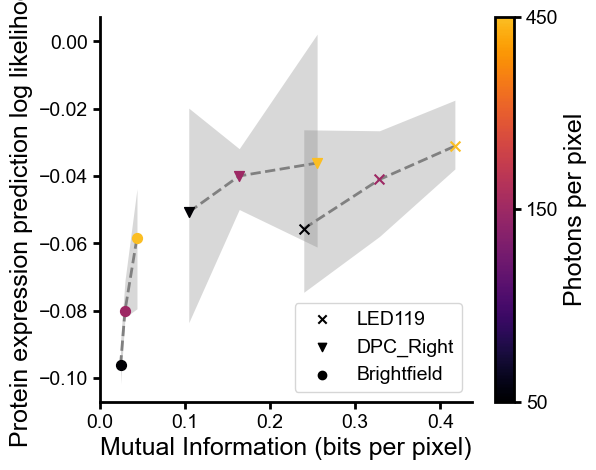

In [4]:
confidence_level = 0.9
# mi_estimates_to_use = mi_estimates_gp
mi_estimates_to_use = mi_estimates_pixel_cnn


# Choose a base colormap
base_colormap = plt.cm.get_cmap('inferno')

# Define the start and end points--used so that high values aren't too light against white background
start, end = 0, 0.85

from matplotlib.colors import LinearSegmentedColormap
# Create a new colormap from the portion of the original colormap
colormap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_colormap.name, a=start, b=end),
    base_colormap(np.linspace(start, end, 256))
)



fig, ax = plt.subplots(1, 1, figsize=(6, 5))


# iterate through all the tuples and make a scatter plot
for channel, photons_per_pixel, replicate in mi_estimates_to_use.keys():
    mi = mi_estimates_to_use[(channel, photons_per_pixel, replicate)]
    nlls = phenotype_nlls[(channel, photons_per_pixel, replicate)]
    marker_indices = phenotype_marker_indices[(channel, photons_per_pixel, replicate)]

    # single trial
    # ax.scatter(mi, -np.mean(nlls), color=color, marker=marker_for_channel(channel))

# sort by channel and photons per pixel
channel_photons_results = {}
for (c, p, r) in mi_estimates_to_use.keys():
    if c not in channel_photons_results:
        channel_photons_results[c] = {}
    if p not in channel_photons_results[c]:
        channel_photons_results[c][p] = []
    mi = mi_estimates_to_use[(c, p, r)]
    nlls = phenotype_nlls[(c, p, r)]
    channel_photons_results[c][p].append((mi, nlls.mean()))

# plot the mean and std for each channel
for channel in channel_photons_results.keys():
    # take mean of each photon per pixel
    mi_center = []
    mi_lower = []
    mi_upper = []

    nll_center = []
    nll_lower = []
    nll_upper = []
    photons_per_pixel = sorted(channel_photons_results[channel].keys())
    for photons in photons_per_pixel:
        mi, nll = zip(*channel_photons_results[channel][photons])
        
        # mi_center.append(np.percentile(mi, 20))
        mi_center.append(np.min(mi))

        # generate 1000 random resamples of nll
        nll_resamples = []
        for i in range(1000):
            nll_resamples.append(np.median(np.random.choice(nll, size=len(nll), replace=True)))
        nll_resamples = np.array(nll_resamples)
        nll_center.append(np.median(nll))
        nll_lower.append(np.percentile(nll_resamples, 100 - 100 * (1 + confidence_level) / 2))
        nll_upper.append(np.percentile(nll_resamples, 100 * (1 + confidence_level) / 2))

        color = color_for_photon_level(photons)
        print(color)
        # median estimate marker
        ax.scatter(mi_center[-1], -nll_center[-1], color=color, marker=marker_for_channel(channel), s=50, zorder=100)
        # make a horizontal line for the error bar
        # ax.plot([mi_lower[-1], mi_upper[-1]], [-nll_center[-1], -nll_center[-1]], color=color, linewidth=2, zorder=100)

    mi_center = np.array(mi_center)
    nll_center = np.array(nll_center)
    nll_lower = np.array(nll_lower)
    nll_upper = np.array(nll_upper)
    
    # trendline for each contrast
    ax.plot(mi_center, -nll_center, '--', color='grey', alpha=1, linewidth=2)




    # error bars

    ax.fill_between(mi_center, -nll_lower, -nll_upper, color='grey', alpha=0.3, linewidth=0, zorder=-100)


ax.set_xlabel('Mutual Information (bits per pixel)')
ax.set_ylabel('Protein expression prediction log likelihood')
clear_spines(ax)


# legend
ax.scatter([], [], color='k', marker='x', label='LED119')
ax.scatter([], [], color='k', marker='v', label='DPC_Right')
ax.scatter([], [], color='k', marker='o', label='Brightfield')
ax.legend(loc='lower right', frameon=True)
ax.set_xlim([0, None])



norm = mpl.colors.Normalize(vmin=min_log_photons, vmax=max_log_photons)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=(np.log(photon_levels)))
# set tick labels
cbar.ax.set_yticklabels(photon_levels)


cbar.set_label('Photons per pixel')

# ax.set_ylim([-.15, None])

# save as pdf
fig.savefig('/home/hpinkard_waller/figures/phenotyping/phenotyping_vs_mi.pdf', transparent=True)


In [5]:
# plot some example images

config_file_name = [d for d in os.listdir(os.path.join(experiment_dir, dir_name)) if '.yaml' in d][0]
config_file_full_path = os.path.join(experiment_dir, dir_name, config_file_name)
config = yaml.load(open(config_file_full_path, 'r'), Loader=yaml.FullLoader)

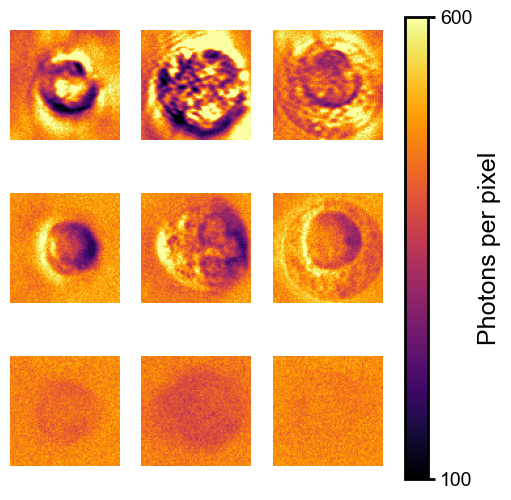

In [39]:
photons_per_pixel = 450
vmin = 50
vmax = 100

# # take vmin and vmax as 1st and 99th percentile over all channels
# vmin = 19999
# vmax = 0
# for i, channel in enumerate(['LED119', 'DPC_Right', 'Brightfield']):
#     images = load_bsccm_images(bsccm, channel=channel, indices=[21, 36, 115], edge_crop=22)
#     images = images / np.mean(images) * photons_per_pixel
#     vmin = min(vmin, np.percentile(images, 1))
#     vmax = max(vmax, np.percentile(images, 99))



fig, ax = plt.subplots(3, 3, figsize=(6, 6))

for i, channel in enumerate(['LED119', 'DPC_Right', 'Brightfield']):

    images = load_bsccm_images(bsccm, channel=channel, indices=[21, 36, 115], edge_crop=22)
    photon_fraction = photons_per_pixel / np.mean(images)
    images = add_shot_noise_to_experimenal_data(images, photon_fraction)


    for j, image in enumerate(images):
        ax[i, j].imshow(image, cmap='inferno', vmin=vmin, vmax=vmax)
        ax[i, j].axis('off')

# add a colorbar
sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[vmin, vmax])
cbar.set_label('Photons per pixel')

fig.savefig('/home/hpinkard_waller/figures/phenotyping/fig_3_examples_images.pdf', transparent=True)